In [2]:
import pandas as pd
import glob
import os
import re

import re
import pandas as pd
import os
import pytz
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import warnings
from concurrent.futures import ThreadPoolExecutor
import shutil

##### Date range correction
* Only dates after July 2023 will be taken

In [2]:
# Hourly average time shiftinhg
dir = "merged"
files = [d for d in os.listdir(dir) if d.endswith('.csv')]
# subdirs = ["Badda Home"]
for file in tqdm(files, desc="Processing homes"):
    print('='*50)
    print(f"Processing {file}")
    filedir = os.path.join(dir, file)
    df = pd.read_csv(filedir, parse_dates=['UTCDateTime'])
    df["BDDateTime"] = df['UTCDateTime'] + pd.Timedelta(hours=6)
    df.to_csv(filedir, index=False)

Processing homes:   0%|          | 0/10 [00:00<?, ?it/s]

Processing R1.csv
Processing R2.csv
Processing R3.csv
Processing R4.csv
Processing SU1.csv
Processing SU2.csv
Processing U1.csv
Processing U2.csv


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_4404\2167184787.py:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filedir, parse_dates=['UTCDateTime'])


KeyboardInterrupt: 

In [3]:
dir = "merged"
# files = [d for d in os.listdir(dir) if d.endswith('.csv')]
files = ['R4.csv']
for file in files:
    print('='*50)
    print(f"Processing {file}")
    
    df = pd.read_csv(os.path.join(dir, file), parse_dates=['BDDateTime'])
    df = df[df['BDDateTime'] >= pd.to_datetime("2023-07-01", format = "%Y-%m-%d")]
    df = df[df['BDDateTime'] <= pd.to_datetime("2025-08-10", format = "%Y-%m-%d")]
    df.to_csv(os.path.join(dir, file), index=False)

Processing R4.csv


Processed Dhakeshwari Home


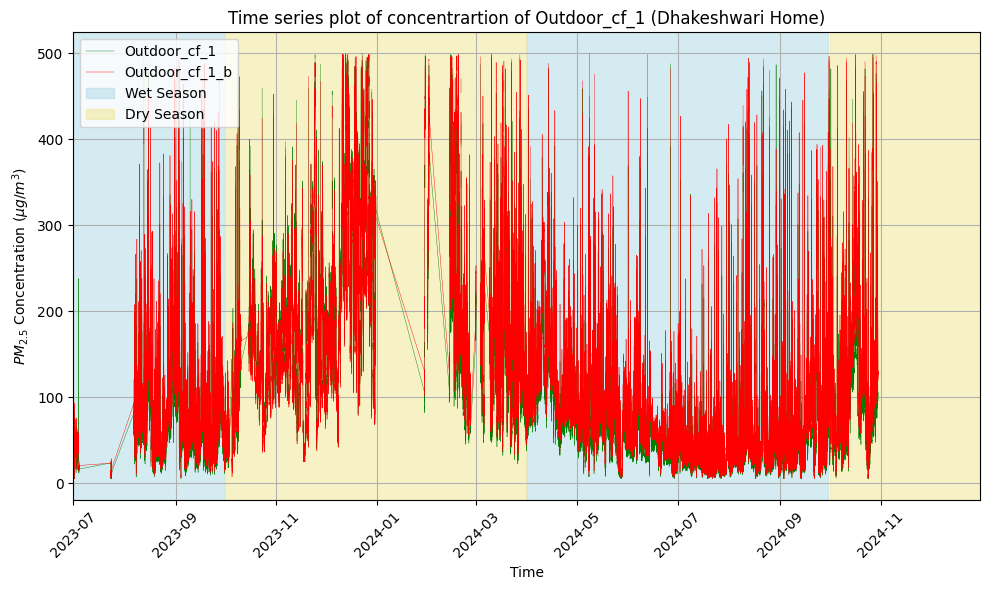

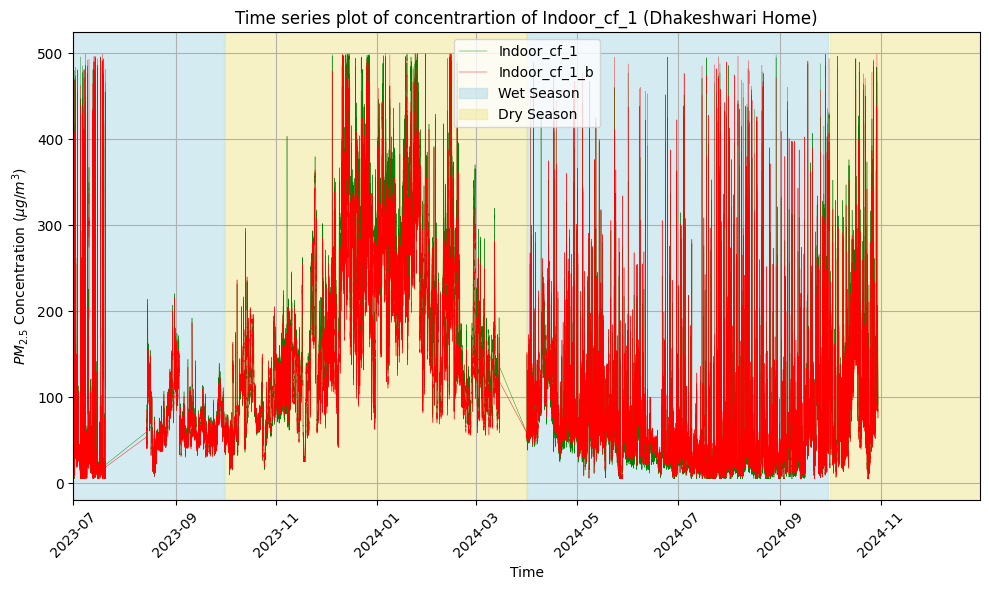

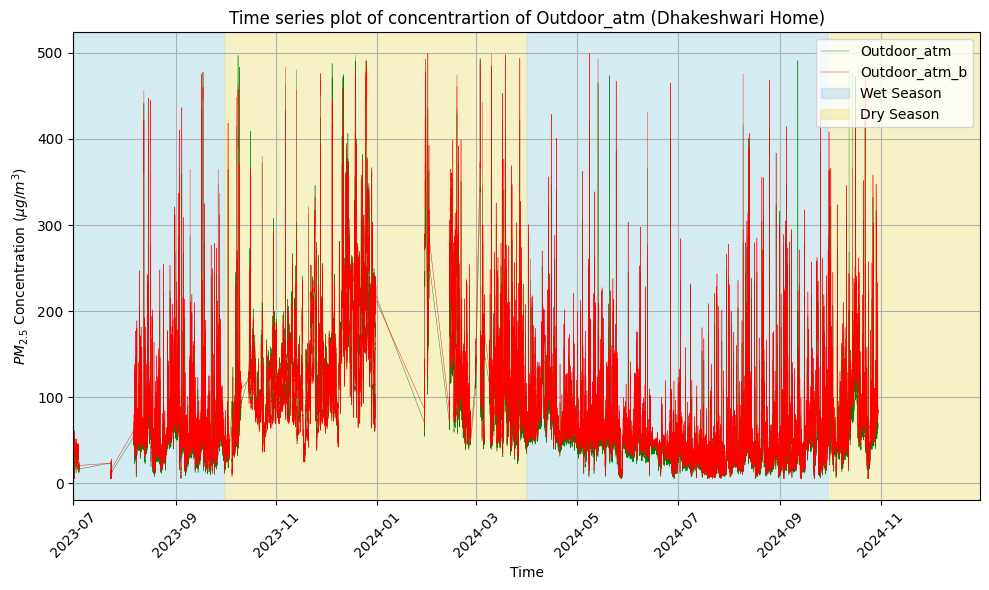

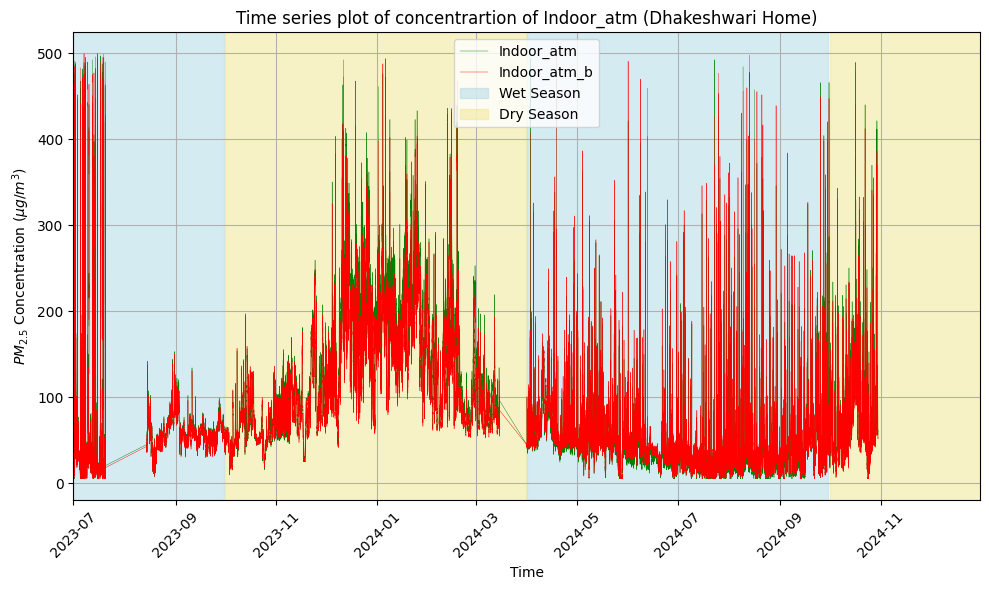

Processed Mohakhali Home


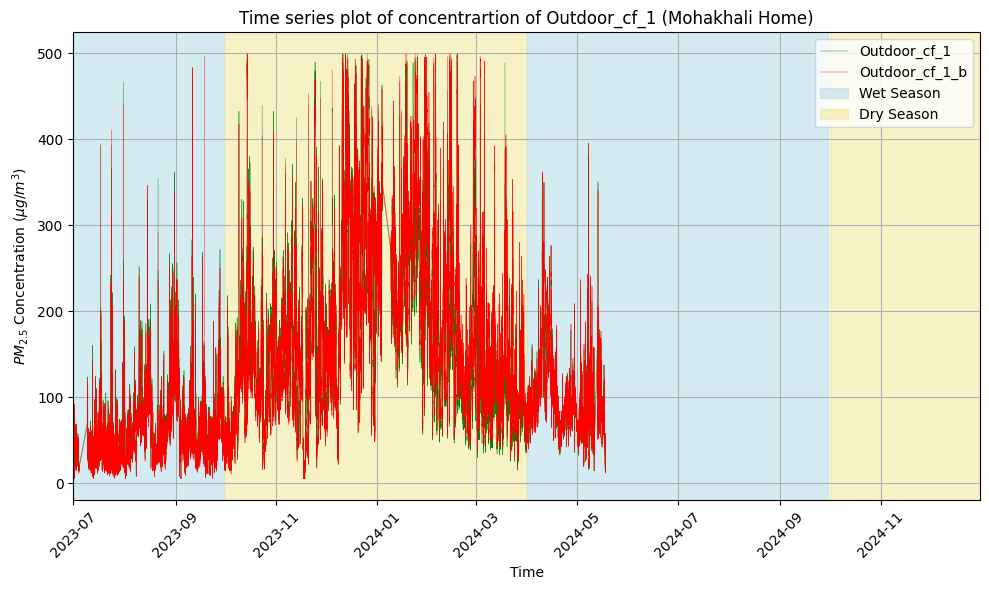

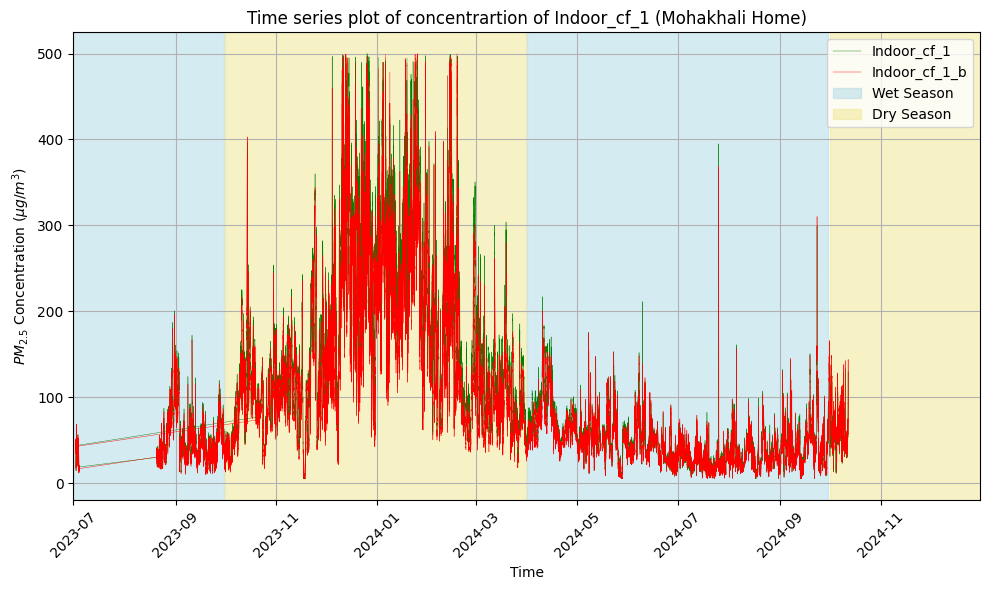

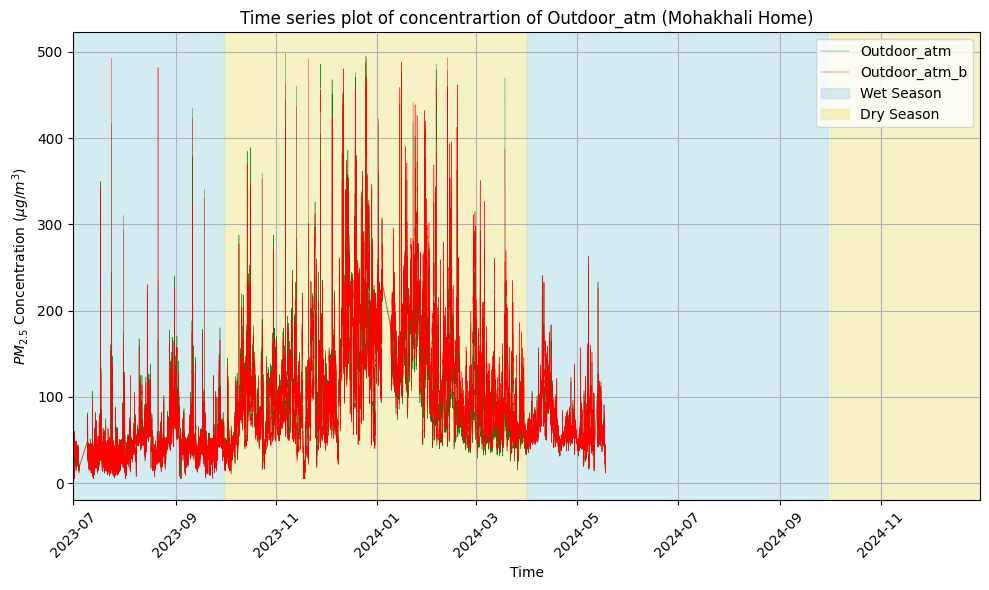

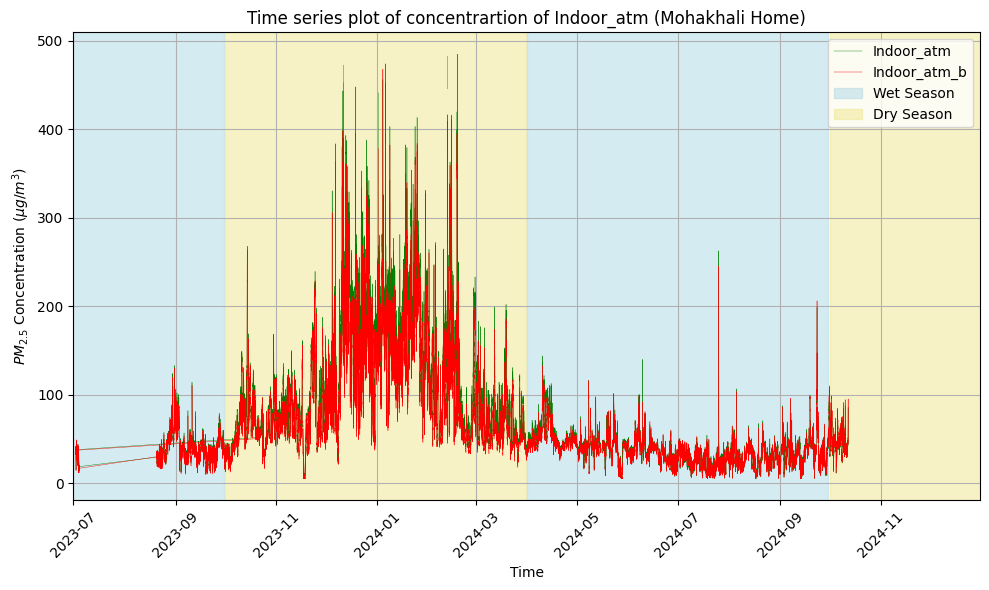

Processed Mohammadpur Home


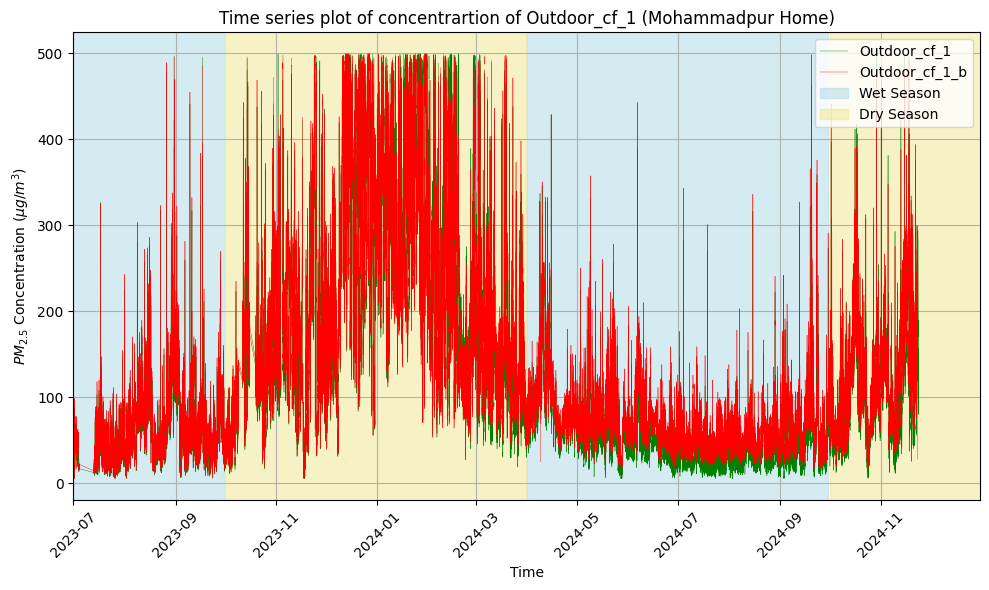

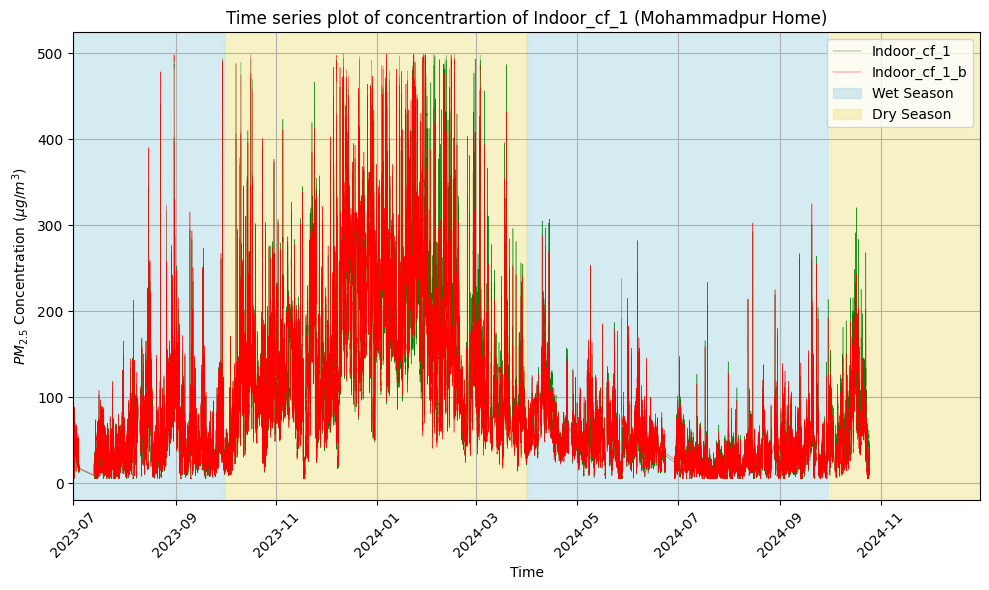

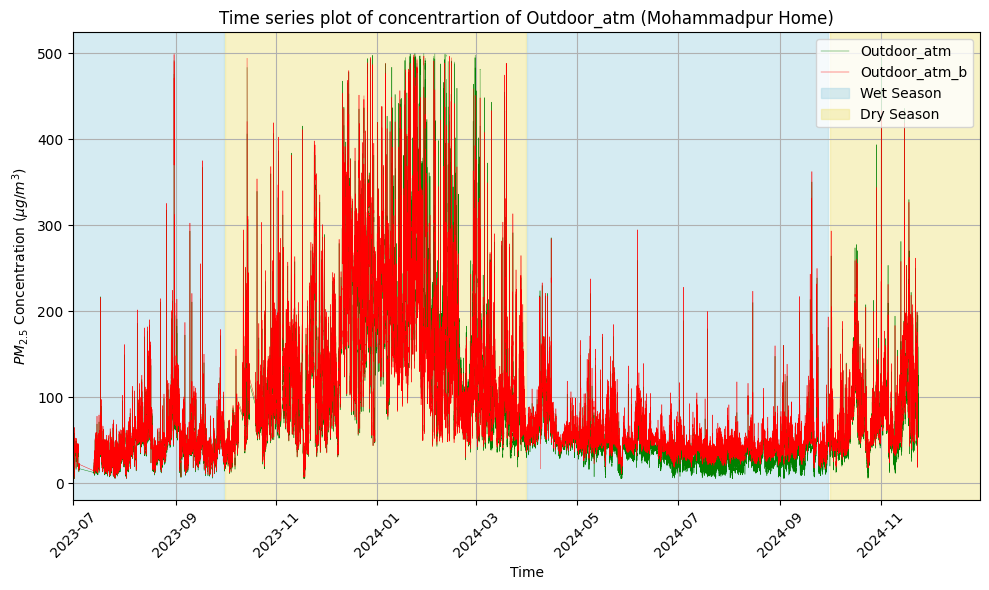

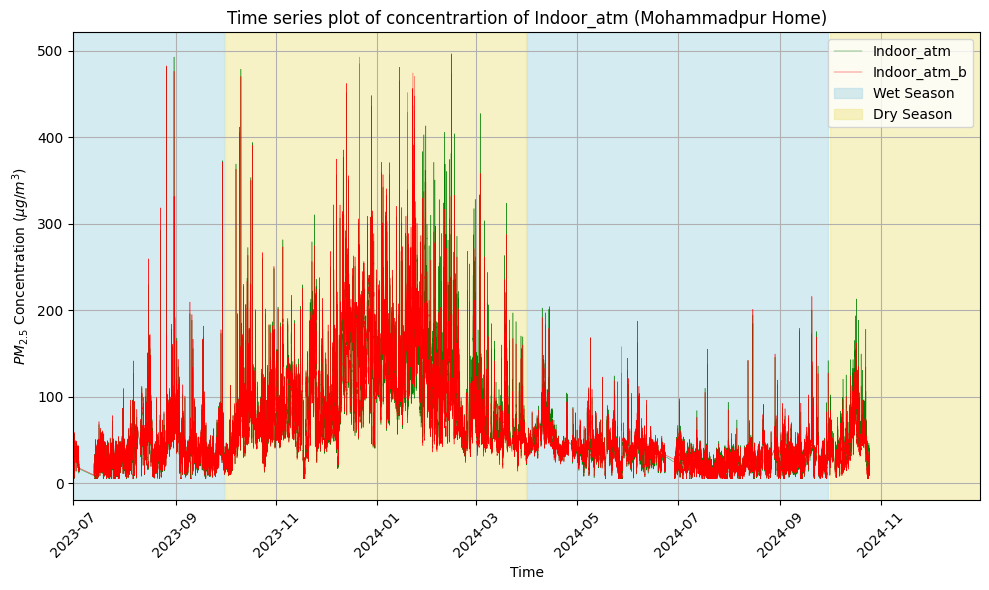

Processed Ajimpur Home


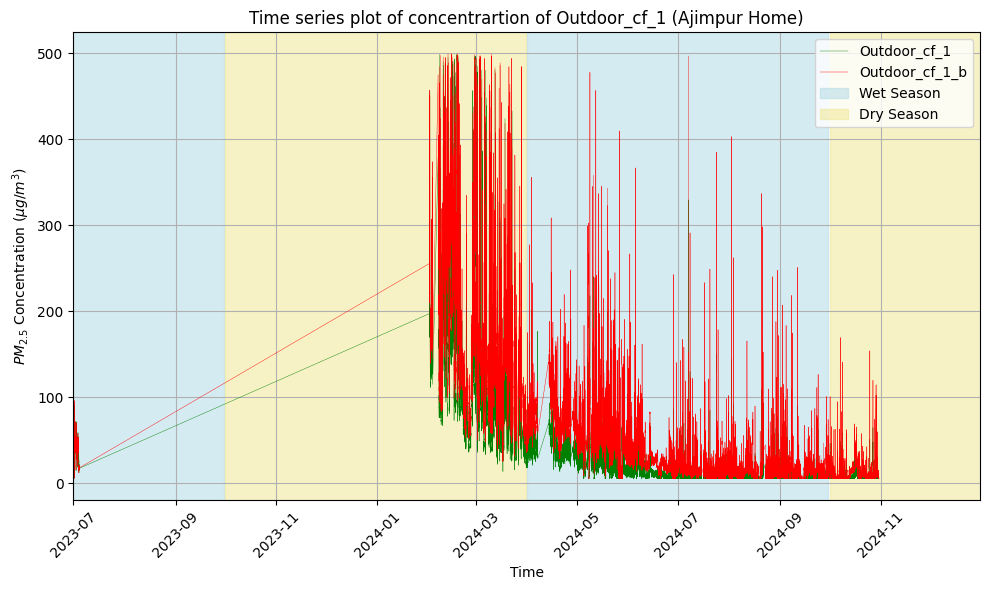

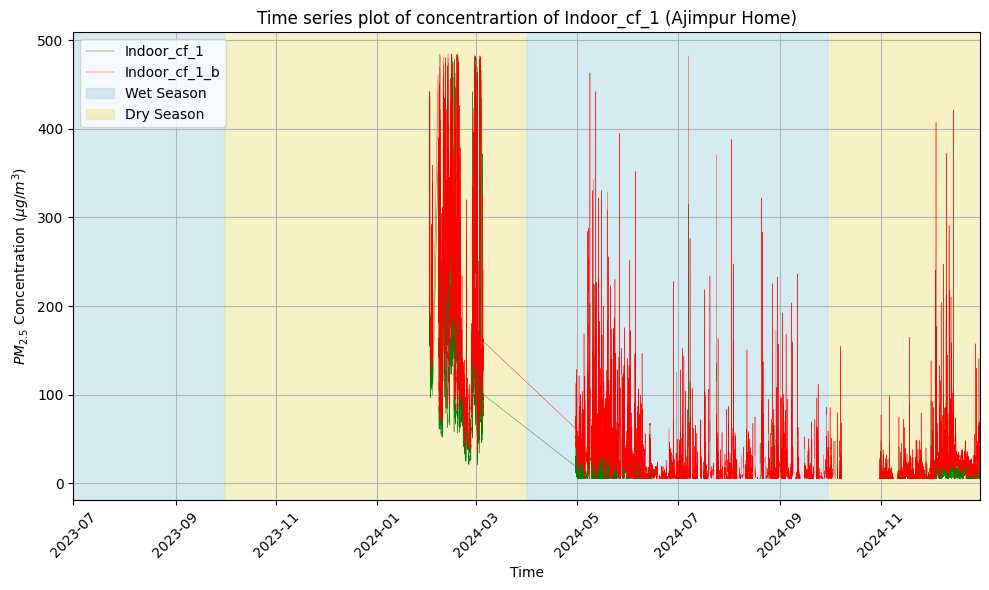

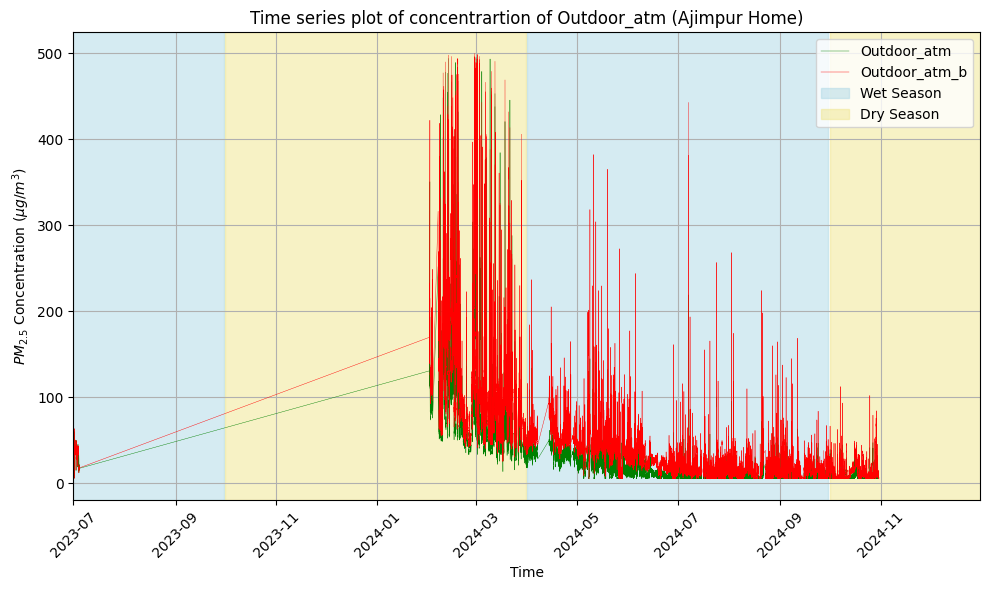

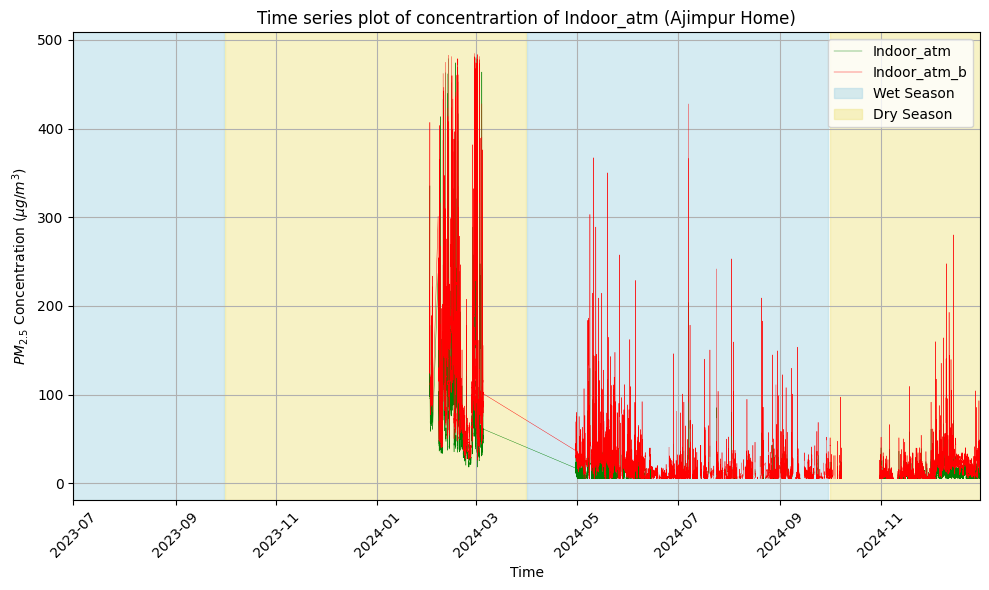

Processed Badda Home


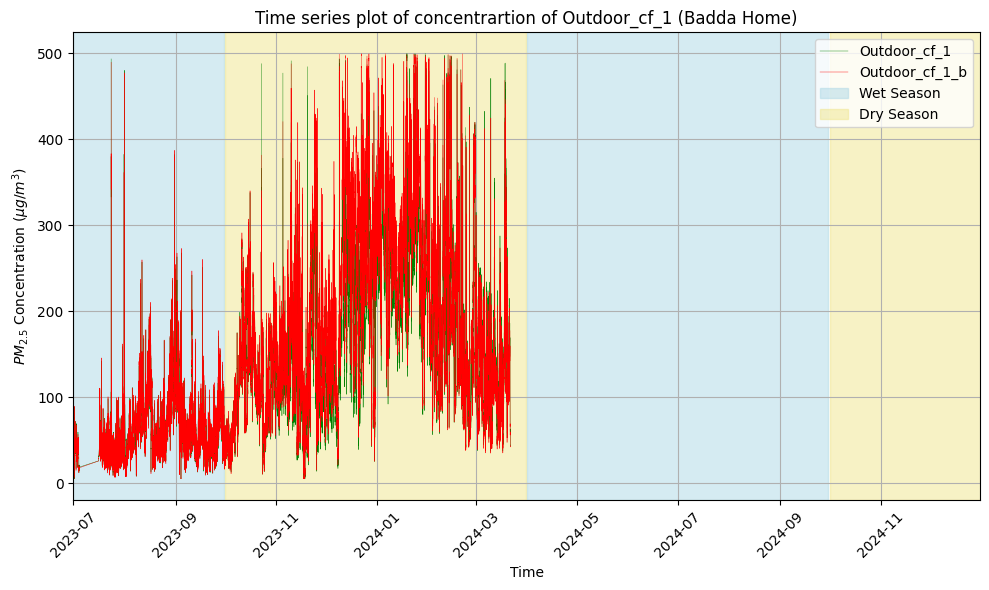

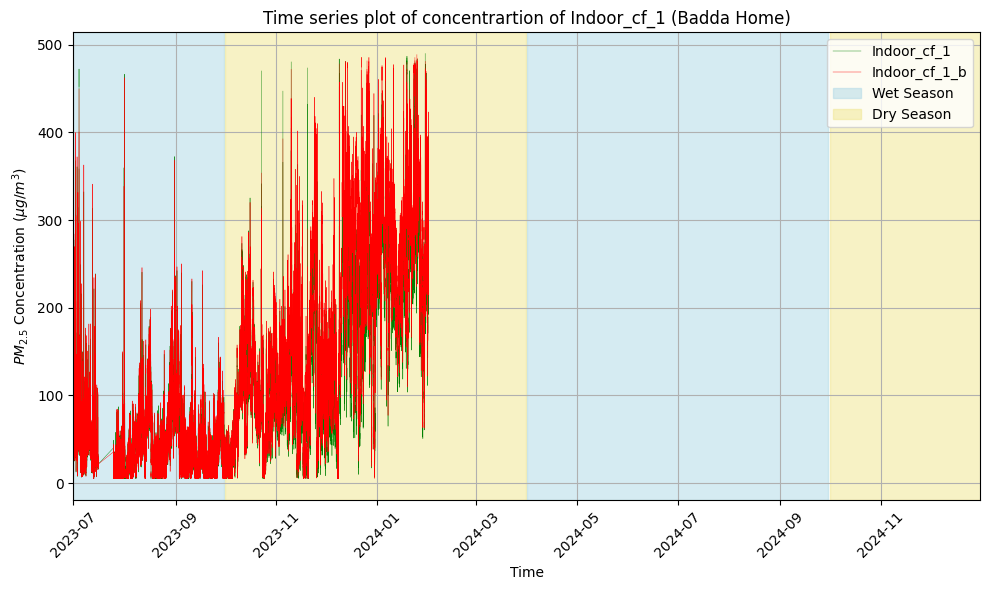

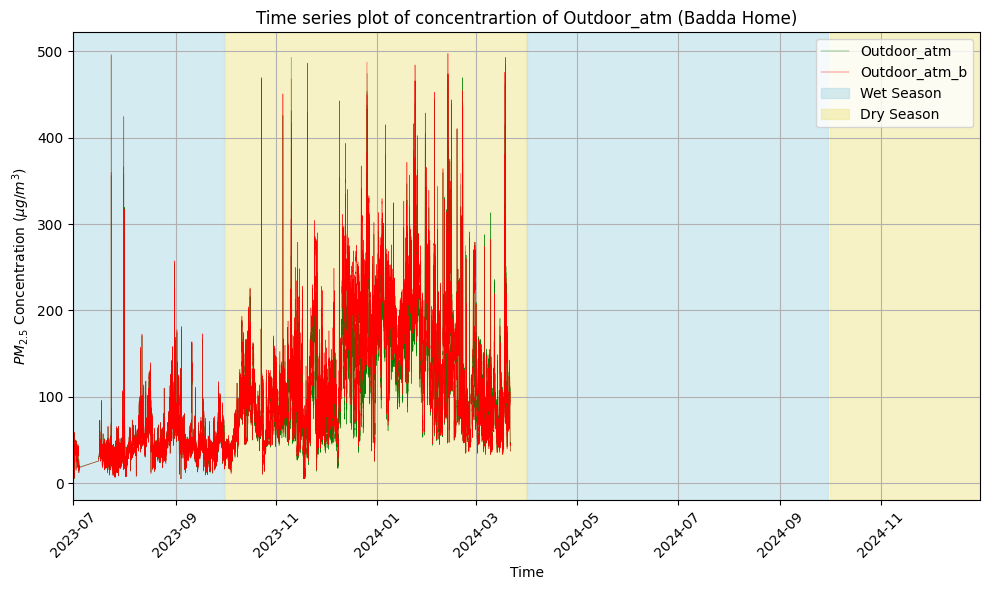

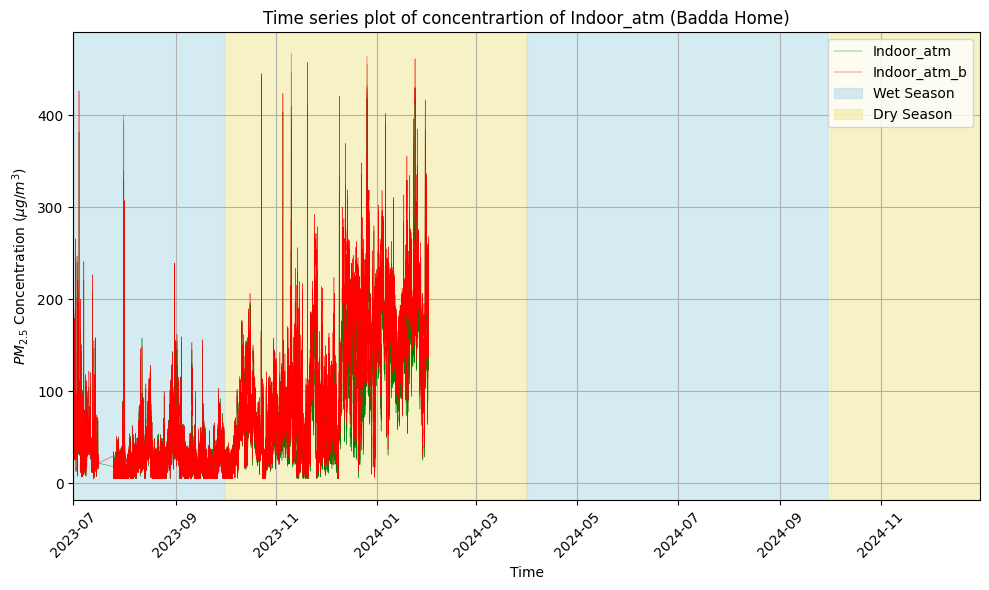

Processed Banasree Home


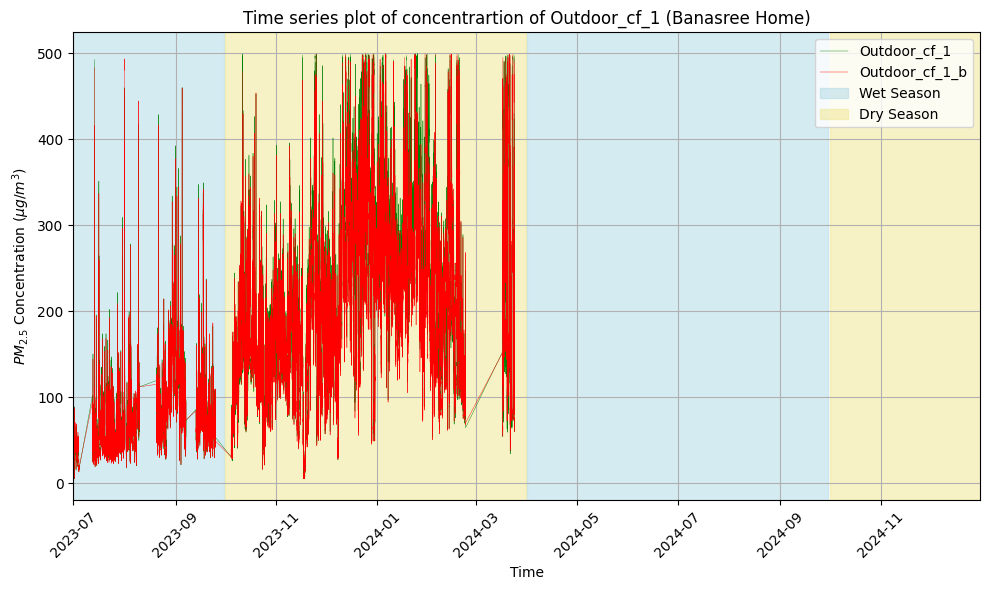

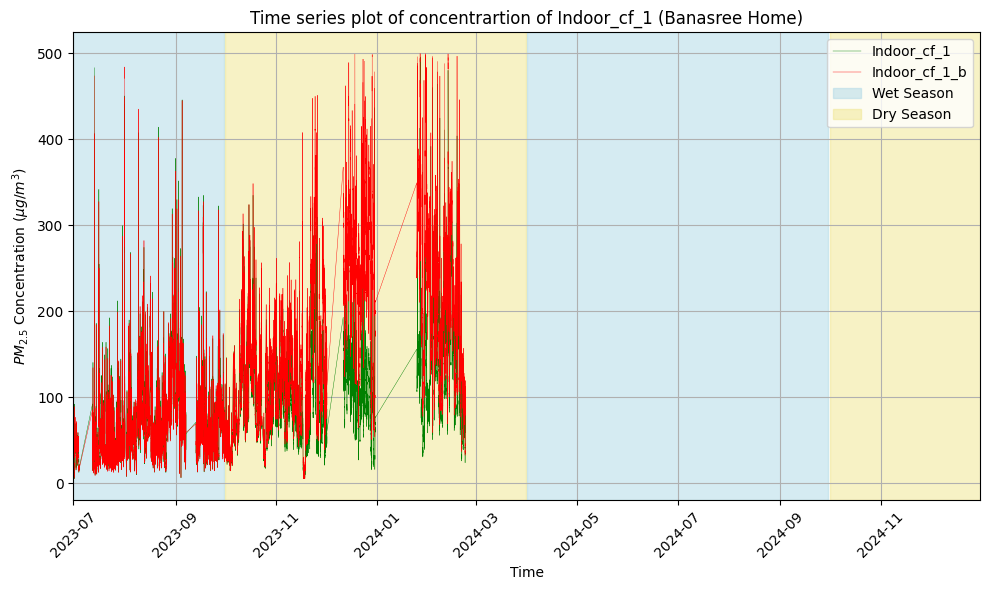

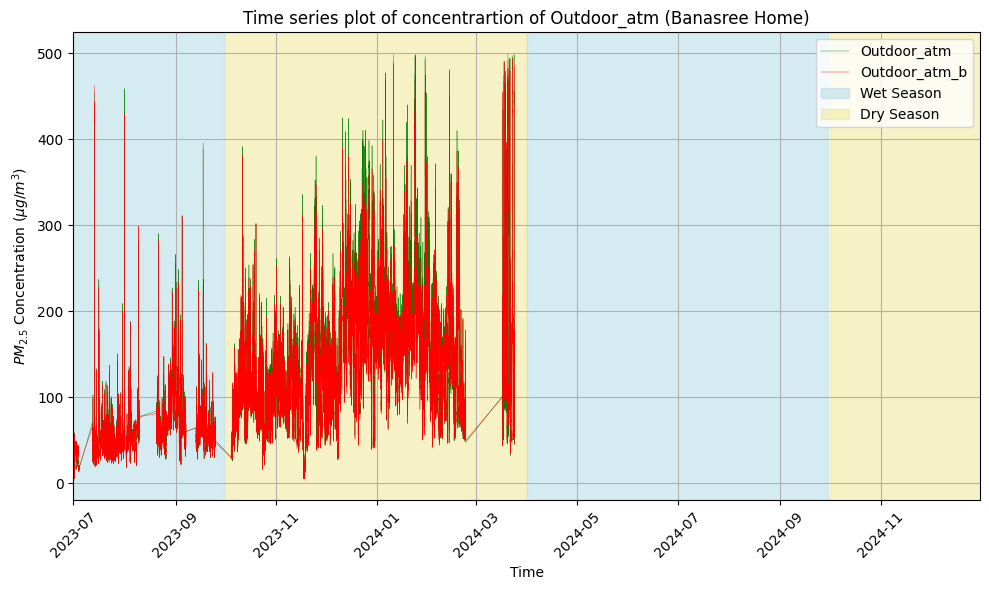

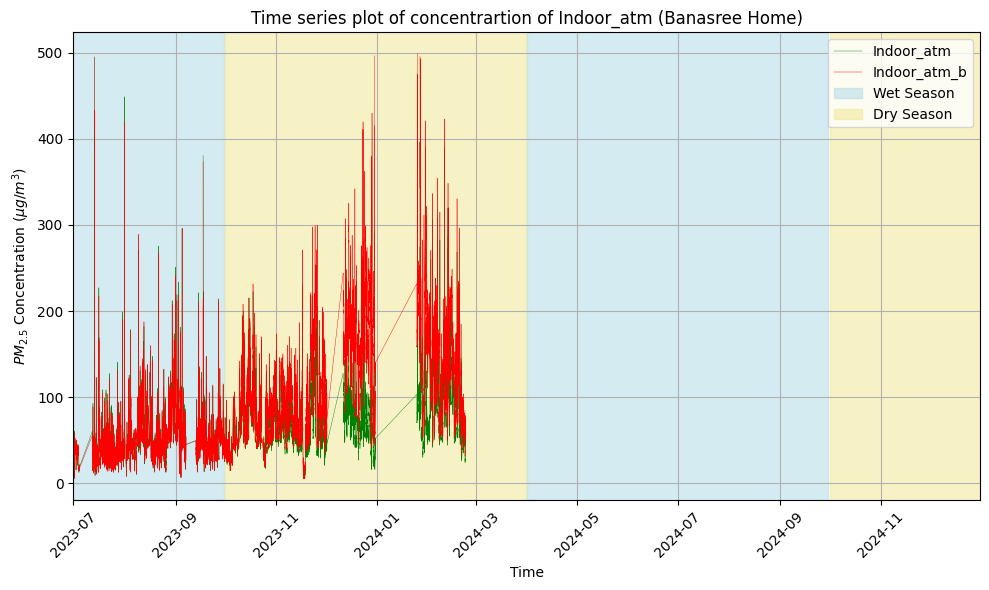

Processed Dania Home


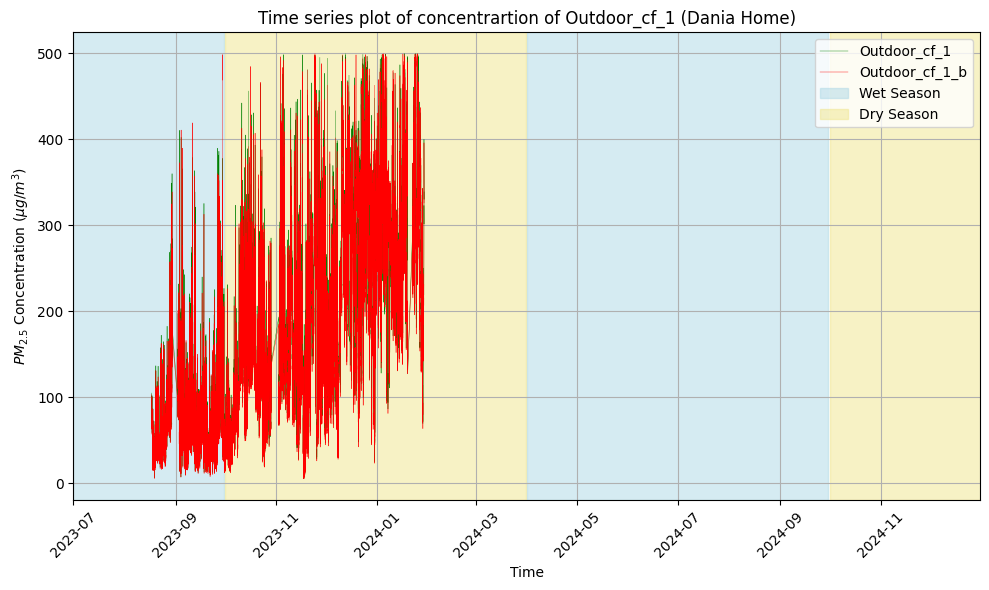

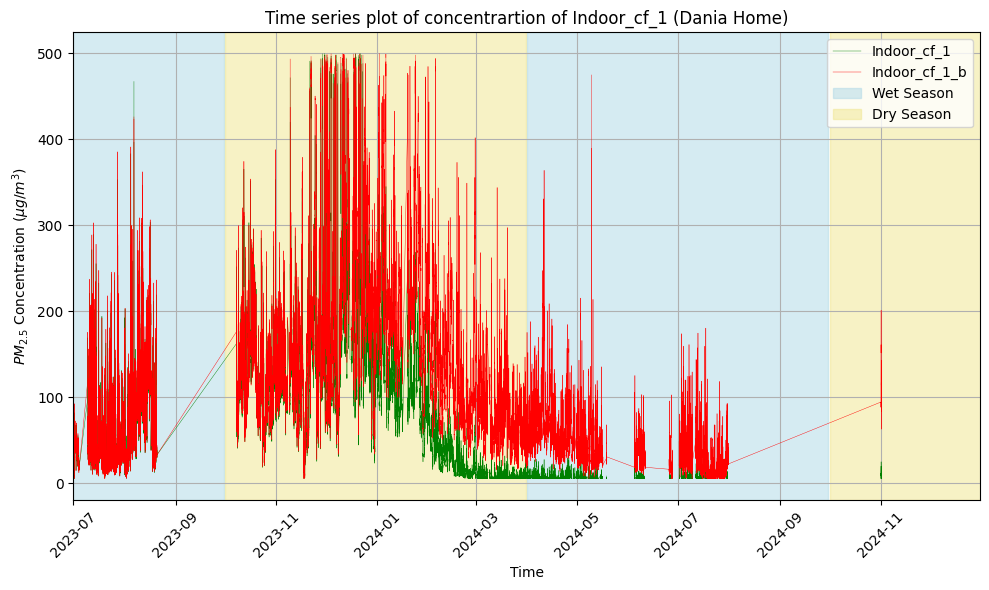

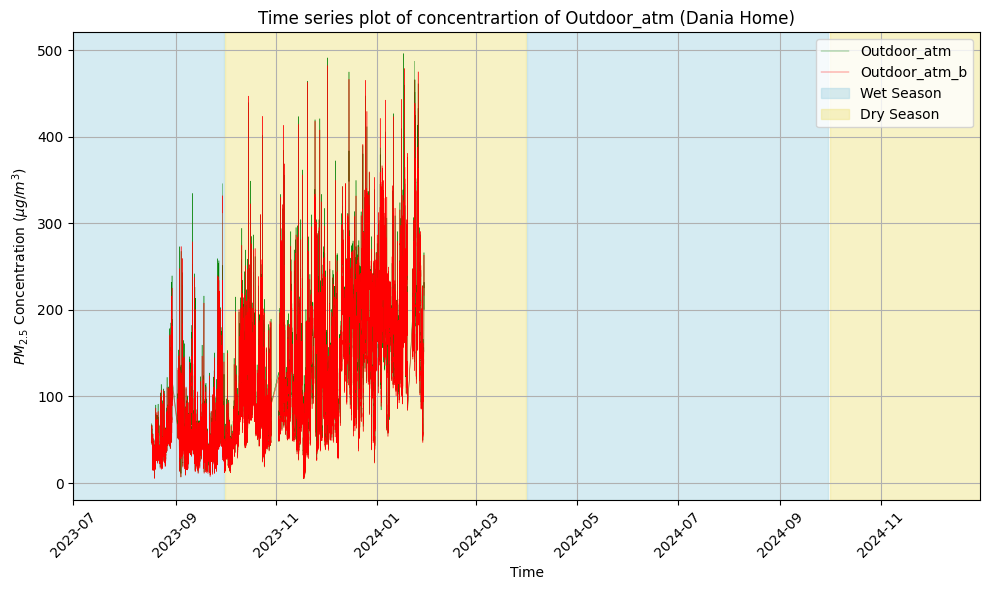

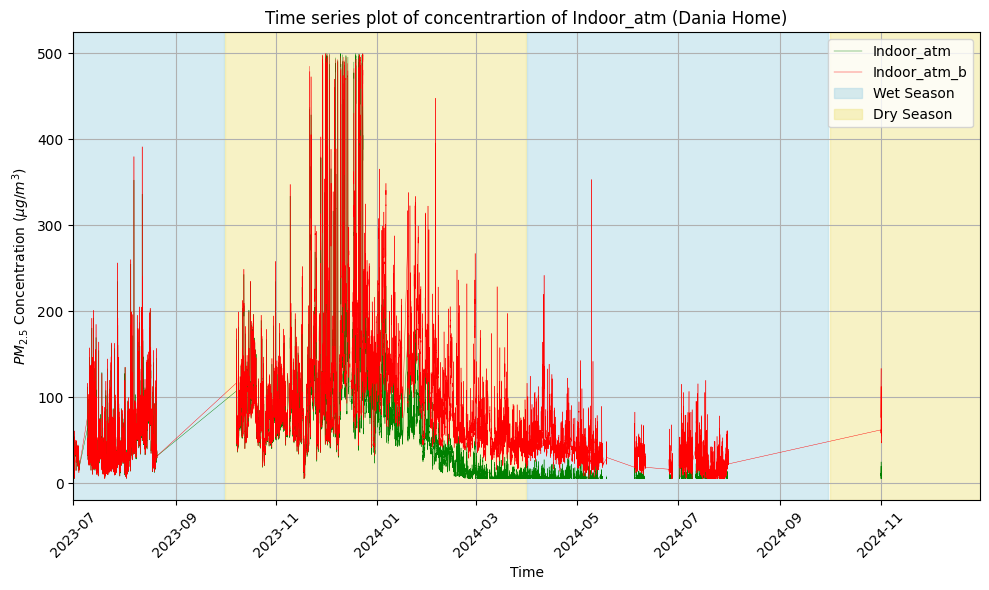

Processed Khilgawn Home


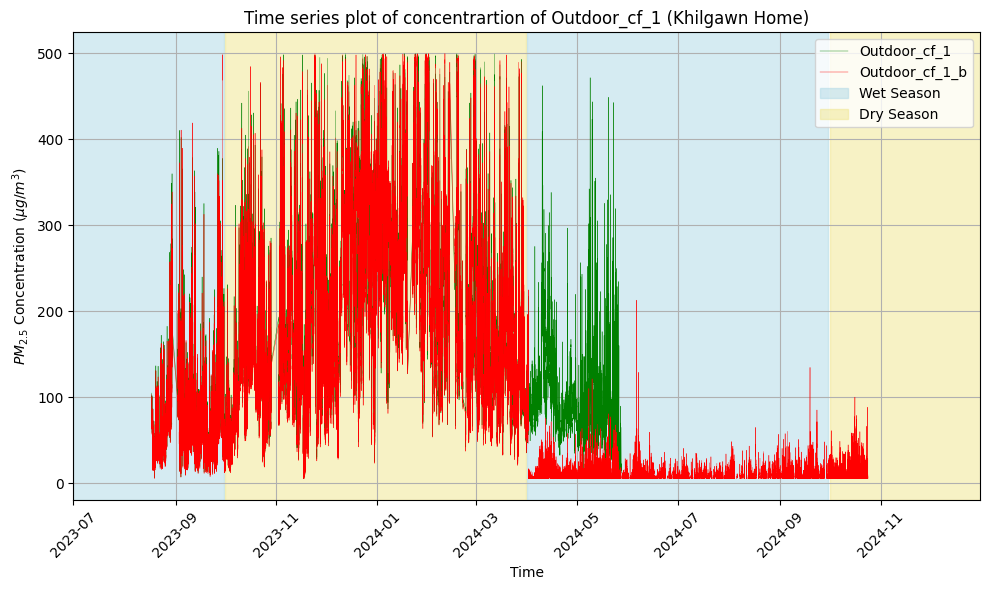

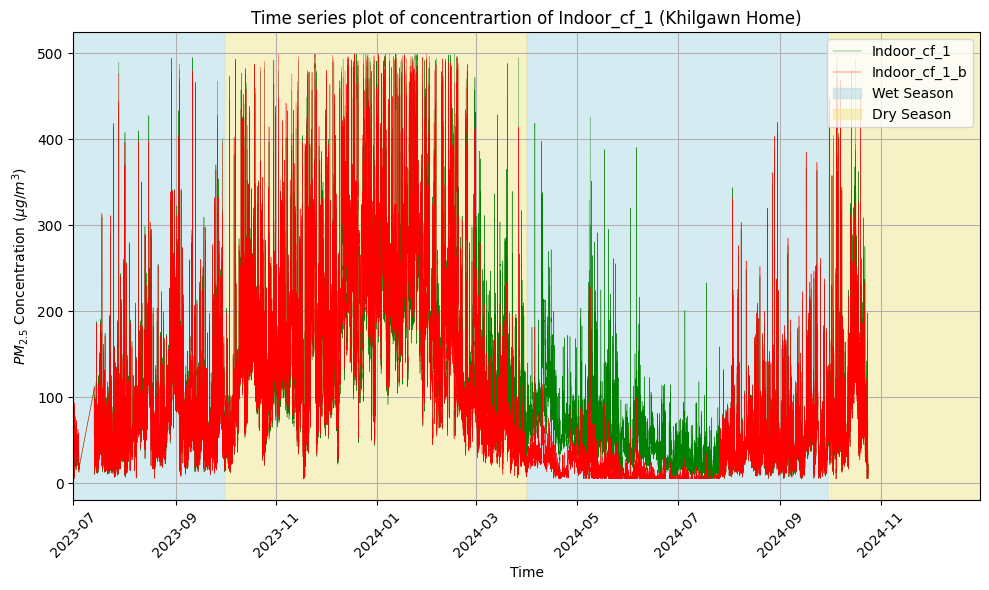

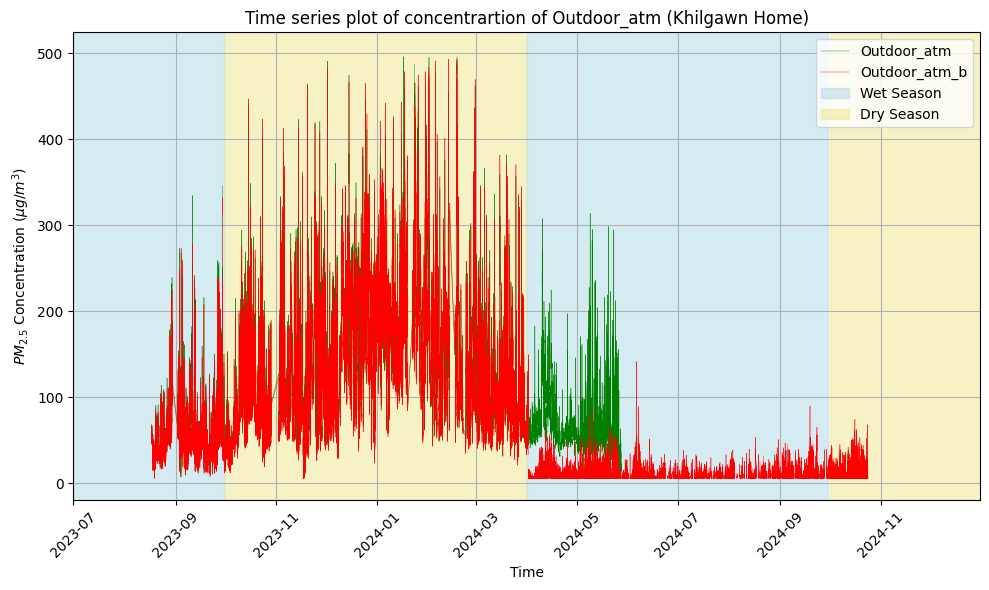

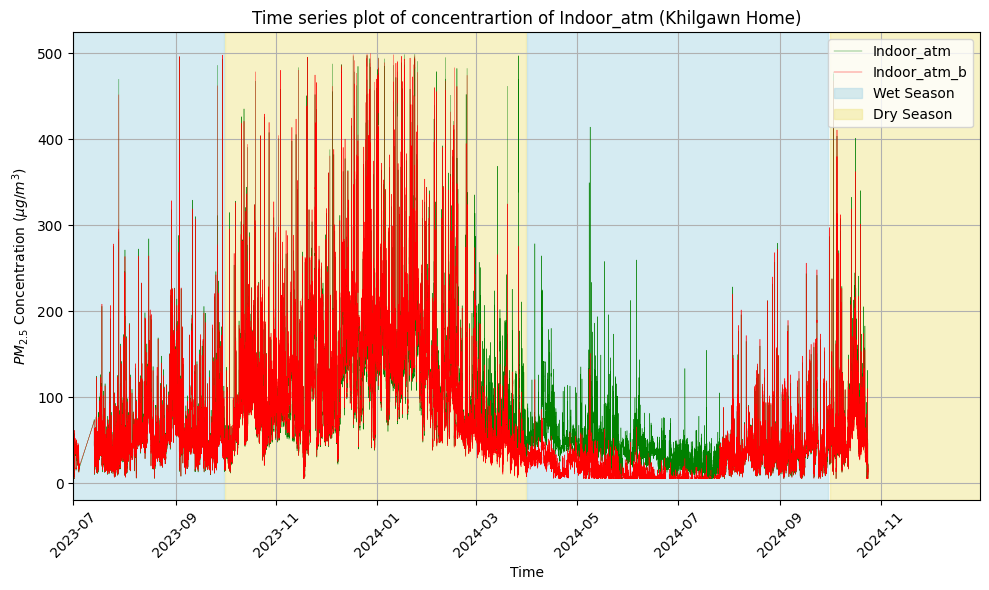

Processed Nakhalpara Home


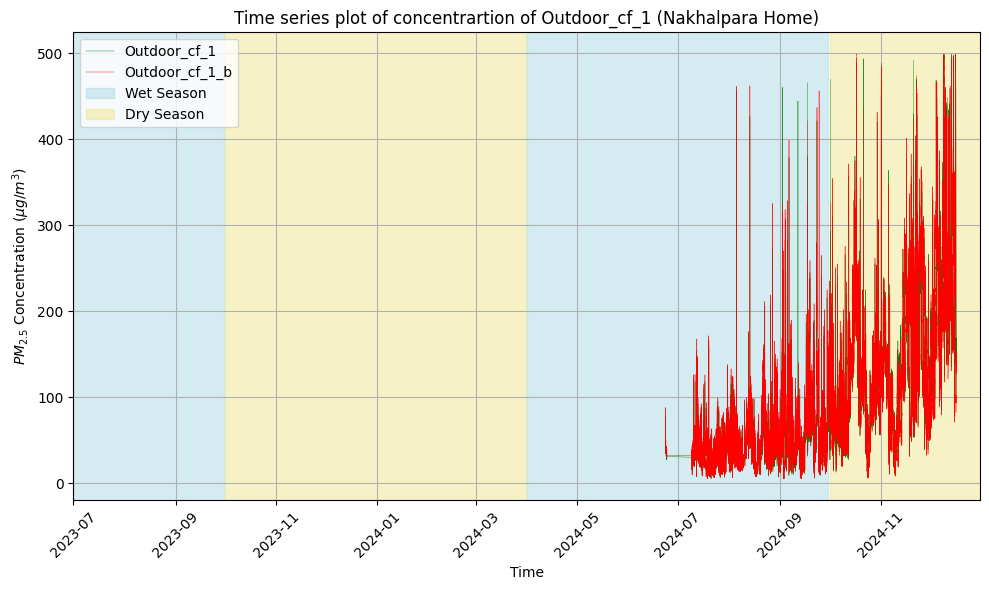

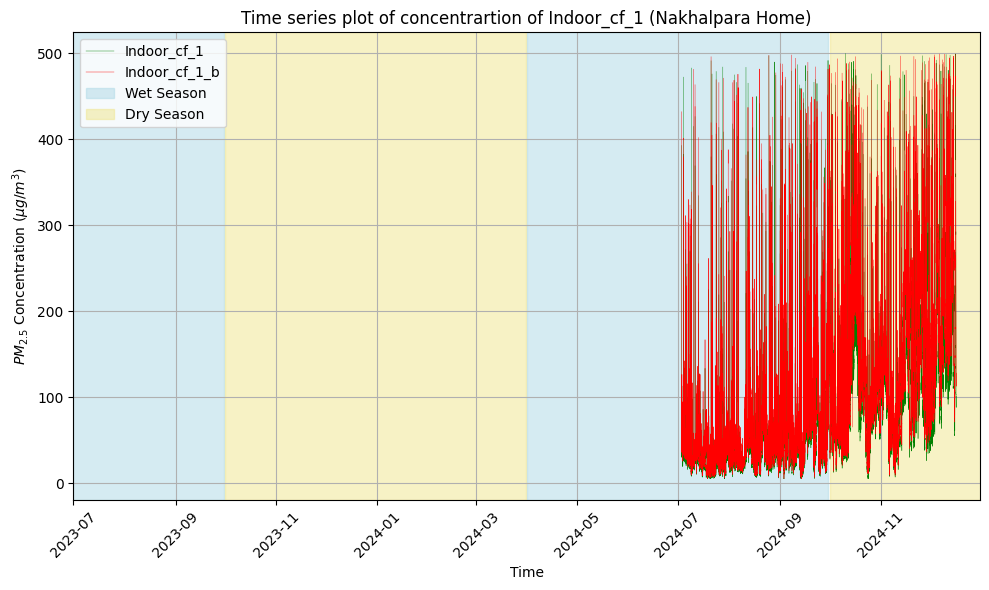

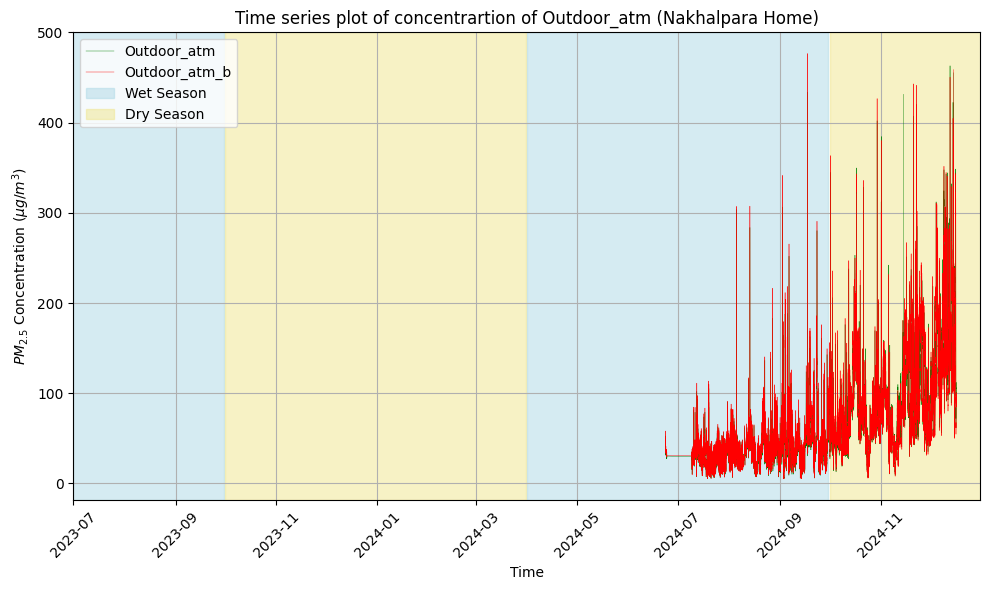

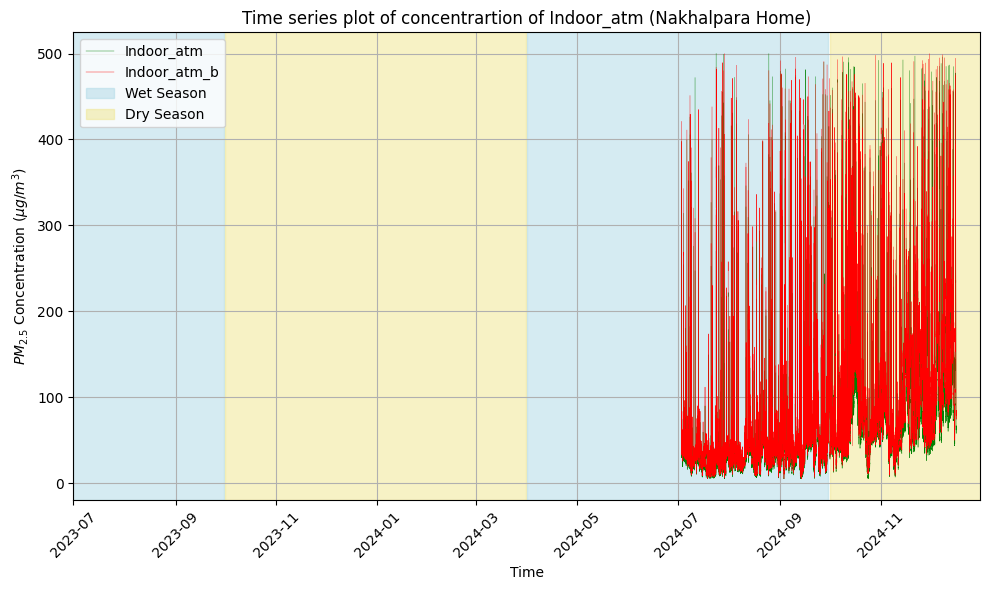

In [23]:
## Plotting (40 plots)

## plotting

dir = 'Data/Raw Clone'

subdirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d)) if "Home" in d]

for home in subdirs:

    indoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Indoor_merged.csv')
    indoor_df['BDDateTime'] = pd.to_datetime(indoor_df['BDDateTime'])
    outdoor_df = pd.read_csv(f'Data/Raw Clone/{home}/Outdoor_merged.csv')
    outdoor_df['BDDateTime'] = pd.to_datetime(outdoor_df['BDDateTime'])
    print(f"Processed {home}")

    def singleFigure(time, data1, data2, home, label, color = None, save = False):
        plt.figure(figsize=(10, 6))

        # Plot the PM2.5 concentrations
        plt.plot(time, data1, label=label, color='green', linestyle='-', markersize=3, linewidth = .3)
        plt.plot(time, data2, label=label + '_b', color='red', linestyle='-', markersize=3, linewidth = .3)

        # Define the background shading for wet and dry seasons
        start_date = 2023
        end_date =  2025

        for year in range(start_date, end_date):
            plt.axvspan(pd.Timestamp(f'{year}-04-01'), pd.Timestamp(f'{year}-09-30'), color='lightblue', alpha=0.5, label='Wet Season' if year == start_date else '')  # Wet season
            plt.axvspan(pd.Timestamp(f'{year}-10-01'), pd.Timestamp(f'{year+1}-03-31'), color='khaki', alpha=0.5, label='Dry Season' if year == start_date else '')  # Dry season

        # Labels and title
        plt.xlabel('Time')
        plt.ylabel(r'$PM_{2.5}$ Concentration ($\mu g/m^3$)')
        plt.title(f'Time series plot of concentrartion of {label.split(' ')[0]} ({home})')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)  # Rotate time labels for better visibility
        plt.tight_layout()
        plt.xlim(
            pd.to_datetime("2023-07-01"),
            pd.to_datetime("2024-12-31")
        )
        if save: plt.savefig(os.path.join("time series" ,f"{home}_{label}.png"), dpi = 300)
        plt.show()

    singleFigure(outdoor_df['BDDateTime'], outdoor_df['pm2_5_cf_1'], outdoor_df['pm2_5_cf_1_b'], home, 'Outdoor_cf_1', "red", True)
    singleFigure(indoor_df['BDDateTime'], indoor_df['pm2_5_cf_1'], indoor_df['pm2_5_cf_1_b'],home, 'Indoor_cf_1', "green", True)
    singleFigure(outdoor_df['BDDateTime'], outdoor_df['pm2_5_atm'], outdoor_df['pm2_5_atm_b'],home, 'Outdoor_atm', "red", True)
    singleFigure(indoor_df['BDDateTime'], indoor_df['pm2_5_atm'], indoor_df['pm2_5_atm_b'], home, 'Indoor_atm', "green", True)


##### Combinig 2 channels 
* either on average, or one of the channels

In [8]:
## merging channel

conditions =   {
    'R1' : 'avg',
    'R2' : 'b',
    'R3' : 'avg',
    'R4' : 'a',

    'SU1' : 'avg',
    'SU2' : 'avg',

    'U1' : 'avg',
    'U2' : 'a',
    'U3' : 'skip',
    'U4' : 'avg'
}

## average calculation
dir = "merged"
target = 'channel_combined'
files = [d for d in os.listdir(dir) if d.endswith('csv')]
for file in tqdm(files):
    print(f'pricessing {file}')

    df = pd.read_csv(os.path.join(dir, file))
    necessary_cols = ['BDDateTime', 'pm2_5_cf_1', 'pm2_5_atm', 'pm2_5_cf_1_b', 'pm2_5_atm_b',]
    df = df[necessary_cols].copy()
    cond = conditions[file.split('.')[0]]
    if cond == 'avg':
        df['pm2_5_cf_1_comb'] = (df['pm2_5_cf_1'] + df['pm2_5_cf_1_b'])/2
        df['pm2_5_atm_comb'] = (df['pm2_5_atm'] + df['pm2_5_atm_b'])/2
    elif cond == 'a':
        df['pm2_5_cf_1_comb'] = df['pm2_5_cf_1']
        df['pm2_5_atm_comb'] = df['pm2_5_atm']
    elif cond == "b":
        df['pm2_5_cf_1_comb'] = df['pm2_5_cf_1_b']
        df['pm2_5_atm_comb'] = df['pm2_5_atm_b']
    elif cond == 'skip':
        continue
    else:
        raise ValueError("cond value not recognized")
    
    df.drop(columns=['pm2_5_cf_1', 'pm2_5_atm', 'pm2_5_cf_1_b', 'pm2_5_atm_b',], inplace=True)
    target_file_dir = os.path.join(target, file)
    df.to_csv(target_file_dir, index=False)
    print("File saved : ", target_file_dir)
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

pricessing R1.csv
File saved :  channel_combined\R1.csv
pricessing R2.csv
File saved :  channel_combined\R2.csv
pricessing R3.csv
File saved :  channel_combined\R3.csv
pricessing R4.csv
File saved :  channel_combined\R4.csv
pricessing SU1.csv
File saved :  channel_combined\SU1.csv
pricessing SU2.csv
File saved :  channel_combined\SU2.csv
pricessing U1.csv
File saved :  channel_combined\U1.csv
pricessing U2.csv


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_21084\186629340.py:25: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(dir, file))


File saved :  channel_combined\U2.csv
pricessing U3.csv


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_21084\186629340.py:25: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(dir, file))


pricessing U4.csv
File saved :  channel_combined\U4.csv


In [3]:
[
# 'UTCDateTime',
#  'mac_address',
#  'firmware_ver',
#  'hardware',
#  'current_temp_f',
#  'current_humidity',
#  'current_dewpoint_f',
#  'pressure',
#  'adc',
#  'mem',
#  'rssi',
#  'uptime',
#  'pm1_0_cf_1',
 'pm2_5_cf_1',
#  'pm10_0_cf_1',
#  'pm1_0_atm',
 'pm2_5_atm',
#  'pm10_0_atm',
#  'pm2.5_aqi_cf_1',
#  'pm2.5_aqi_atm',
#  'p_0_3_um',
#  'p_0_5_um',
#  'p_1_0_um',
#  'p_2_5_um',
#  'p_5_0_um',
#  'p_10_0_um',
#  'pm1_0_cf_1_b',
 'pm2_5_cf_1_b',
#  'pm10_0_cf_1_b',
#  'pm1_0_atm_b',
 'pm2_5_atm_b',
#  'pm10_0_atm_b',
#  'pm2.5_aqi_cf_1_b',
#  'pm2.5_aqi_atm_b',
#  'p_0_3_um_b',
#  'p_0_5_um_b',
#  'p_1_0_um_b',
#  'p_2_5_um_b',
#  'p_5_0_um_b',
#  'p_10_0_um_b',
#  'gas',
 'BDDateTime'
 ]

['pm2_5_cf_1', 'pm2_5_atm', 'pm2_5_cf_1_b', 'pm2_5_atm_b', 'BDDateTime']

##### Appling calibration

In [8]:
## calibration
## (thersholds were applied once again here)

def calibrate_cf_1(time, pm2_5):
    if pd.isnull(time) or pd.isnull(pm2_5):
        return float('nan')
    month = time.month
    if month < 4 or month > 9:
        res =  0.63*pm2_5 - 1.1
    else:
        res =  0.77 * pm2_5 + 6.4
    
    if res >= 5 and res <= 500:
        return res
    else:
        return float('nan')
    
def calibrate_atm(time, pm2_5):
    if pd.isnull(time) or pd.isnull(pm2_5):
        return float('nan')
    month = time.month
    if month < 4 or month > 9:
        res =  0.96*pm2_5 - 2.0
    else:
        res = 1.4 * pm2_5 - 10.23

    if res >= 5 and res <= 500:
        return res
    else:
        return float('nan')


## average calculation
dir = "channel_combined"
files = [f for f in os.listdir(dir) if f.endswith('csv')]
for file in tqdm(files):
    print(f'processing {file}')
        
    df = pd.read_csv(os.path.join(dir, file))
    df['BDDateTime'] = pd.to_datetime(df['BDDateTime'])

    df['pm2_5_cf_1_calibrated'] = df.apply(
        lambda row : calibrate_cf_1(row['BDDateTime'], row['pm2_5_cf_1_comb']), axis = 1
    )
    df['pm2_5_atm_calibrated'] = df.apply(
        lambda row : calibrate_atm(row['BDDateTime'], row['pm2_5_atm_comb']), axis = 1
    )

    df.loc[(df['pm2_5_atm_calibrated'] <= 0) | (df['pm2_5_atm_calibrated'] > 500), 'pm2_5_atm_calibrated'] = float('nan')
    df.loc[(df['pm2_5_cf_1_calibrated'] <= 0) | (df['pm2_5_cf_1_calibrated'] > 500), 'pm2_5_cf_1_calibrated'] = float('nan')


    df.to_csv(os.path.join(dir, file), index=False)
    print("Saved", file)

  0%|          | 0/9 [00:00<?, ?it/s]

processing R1.csv
Saved R1.csv
processing R2.csv
Saved R2.csv
processing R3.csv
Saved R3.csv
processing R4.csv
Saved R4.csv
processing SU1.csv
Saved SU1.csv
processing SU2.csv
Saved SU2.csv
processing U1.csv
Saved U1.csv
processing U2.csv
Saved U2.csv
processing U4.csv
Saved U4.csv


#### Hourly average

In [ ]:
def hourly_averages(df, datas, time='UTCDateTime', name = None):
    results = {"time" : []}
    for col in datas:
        results[col] = []
    for col in datas:
        results[col+"count"] = []
    

    # Ensure the DataFrame has the correct time and data columns
    df = df[datas + [time]].copy()
    # df = df.dropna()  # Remove rows with NaN in time or data columns
    df[time] = pd.to_datetime(df[time])  # Ensure time column is datetime
    df = df.sort_values(by=time)  # Sort by time column

    # Generate specific hourly times for calculation (00:30, 01:30, ..., 23:30)
    start_time = df[time].min().replace(minute=30, second=0, microsecond=0)
    end_time = df[time].max().replace(minute=30, second=0, microsecond=0)
    hourly_times = pd.date_range(start=start_time, end=end_time, freq="1h")

    for target_time in tqdm(hourly_times, desc=f"Taking hourly averages : {name}"):
        # Append the results
        results["time"].append(target_time)
        # Define the 1-hour window (30 minutes before and after)
        start_window = target_time - pd.Timedelta(minutes=30)
        end_window = target_time + pd.Timedelta(minutes=30)
        # Filter data within the window
        window_data_all = df[(df[time] >= start_window) & (df[time] <= end_window)][datas]
        for data in datas:
            # Count the number of data points in the window
            window_data = window_data_all[data].dropna()
            count = len(window_data)
            # Compute the average if the number of points is >= 10
            if count >= 10:
                avg = window_data.mean()
            else:
                avg = np.nan  # Fill with NaN if insufficient data
            
            results[data].append(avg)
            results[data+'count'].append(count)

    # Convert results to a DataFrame for convenience
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
# Hourly average
dir = "channel_combined"
files = [f for f in os.listdir(dir) if f.endswith('.csv')]
for file in tqdm(files, desc="Processing homes"):
    print('='*50)
    print(f"Processing {file}")

    if False and os.path.exists(os.path.join(dir, subdir, f'Hourly_average_{type}.csv')):
        print("file found. skipping")
        continue
    
    df = pd.read_csv(os.path.join(dir, file))
    df['BDDateTime'] = pd.to_datetime(df['BDDateTime'])
    hourly_avg = hourly_averages(df, datas=['pm2_5_atm_calibrated', "pm2_5_cf_1_calibrated"], time='BDDateTime', name = file)
    hourly_avg.to_csv(os.path.join('hourly_averages', file), index=False)
    print(f"saved : {file}")

Processing homes:   0%|          | 0/9 [00:00<?, ?it/s]

Processing R1.csv


Taking hourly averages : R1.csv:   0%|          | 0/16885 [00:00<?, ?it/s]

saved : R1.csv
Processing R2.csv


Taking hourly averages : R2.csv:   0%|          | 0/18125 [00:00<?, ?it/s]

saved : R2.csv
Processing R3.csv


Taking hourly averages : R3.csv:   0%|          | 0/17713 [00:00<?, ?it/s]

saved : R3.csv
Processing R4.csv


Taking hourly averages : R4.csv:   0%|          | 0/18249 [00:00<?, ?it/s]

saved : R4.csv
Processing SU1.csv


Taking hourly averages : SU1.csv:   0%|          | 0/15624 [00:00<?, ?it/s]

saved : SU1.csv
Processing SU2.csv


Taking hourly averages : SU2.csv:   0%|          | 0/17252 [00:00<?, ?it/s]

saved : SU2.csv
Processing U1.csv


Taking hourly averages : U1.csv:   0%|          | 0/17832 [00:00<?, ?it/s]

saved : U1.csv
Processing U2.csv


Taking hourly averages : U2.csv:   0%|          | 0/17944 [00:00<?, ?it/s]

saved : U2.csv
Processing U4.csv


Taking hourly averages : U4.csv:   0%|          | 0/7271 [00:00<?, ?it/s]

saved : U4.csv


#### Daily Average

In [ ]:
def daily_averages(df, datas, time='time', name = None):
    results = {"time" : []}
    for col in datas:
        results[col] = []
        results[col+"count"] = []
    

    # Ensure the DataFrame has the correct time and data columns
    df = df[datas + [time]].copy()
    # df = df.dropna()  # Remove rows with NaN in time or data columns
    df[time] = pd.to_datetime(df[time])  # Ensure time column is datetime
    df = df.sort_values(by=time)  # Sort by time column

    # Generate specific hourly times for calculation (00:30, 01:30, ..., 23:30)
    start_time = df[time].min().replace(hour = 12, minute=00, second=0, microsecond=0)
    end_time = df[time].max().replace(hour = 12, minute=0, second=0, microsecond=0)
    days = pd.date_range(start=start_time, end=end_time, freq="D")

    for target_time in tqdm(days, desc=f"Taking daily averages for {name}"):
        # Append the results
        results["time"].append(target_time)
        # Define the 1-hour window (30 minutes before and after)
        start_window = target_time - pd.Timedelta(hours=12)
        end_window = target_time + pd.Timedelta(hours=12)
        # Filter data within the window
        window_data_all = df[(df[time] >= start_window) & (df[time] <= end_window)][datas]
        for data in datas:
            # Count the number of data points in the window
            window_data = window_data_all[data].dropna()
            count = len(window_data)
            # Compute the average if the number of points is >= 10
            if count >= 20:
                avg = window_data.mean()
            else:
                avg = np.nan  # Fill with NaN if insufficient data
            
            results[data].append(avg)
            results[data+'count'].append(count)

    # Convert results to a DataFrame for convenience
    results_df = pd.DataFrame(results)
    return results_df

In [5]:
# Daily average
dir = "Data/Raw Clone"
subdirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d)) if "Home" in d]
for subdir in tqdm(subdirs, desc="Processing homes"):
    print('='*50)
    print(f"Processing {subdir}")
    merges = ['Hourly_average_merged_calibrated_Outdoor.csv', 'Hourly_average_merged_calibrated_Indoor.csv']
    for file in merges:
        if 'ndoor' in file:
            type = 'Indoor'
        elif 'tdoor' in file:
            type = 'Outdoor'
        else:
            warnings.warn("type cannot be detected", UserWarning)
        if False and os.path.exists(os.path.join(dir, subdir, f'Hourly_average_{type}.csv')):
            print("file found. skipping")
            continue
        
        df = pd.read_csv(os.path.join(dir, subdir, file))
        df['time'] = pd.to_datetime(df['time'])
        daily_avg = daily_averages(df, datas=['current_humidity','current_temp_f','current_dewpoint_f','pressure','pm2_5_cf_1','pm2_5_atm','pm2_5_cf_1_b','pm2_5_atm_b','pm2_5_atm_comb','pm2_5_cf_1_comb','pm2_5_cf_1_calibrated','pm2_5_atm_calibrated'], time='time', subdir = subdir)
        daily_avg.to_csv(os.path.join(dir, subdir, f'Daily_average_merged_calibrated_{type}.csv'), index=False)
        # daily_avg.info()
        print(f"saved : Daily_average_merged_calibrated_{type}.csv")

Processing homes:   0%|          | 0/9 [00:00<?, ?it/s]

Processing Dhakeshwari Home


Taking daily averages for Dhakeshwari Home (None):   0%|          | 0/488 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Outdoor.csv


Taking daily averages for Dhakeshwari Home (None):   0%|          | 0/488 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Indoor.csv
Processing Mohakhali Home


Taking daily averages for Mohakhali Home (None):   0%|          | 0/323 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Outdoor.csv


Taking daily averages for Mohakhali Home (None):   0%|          | 0/469 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Indoor.csv
Processing Mohammadpur Home


Taking daily averages for Mohammadpur Home (None):   0%|          | 0/512 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Outdoor.csv


Taking daily averages for Mohammadpur Home (None):   0%|          | 0/483 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Indoor.csv
Processing Ajimpur Home


Taking daily averages for Ajimpur Home (None):   0%|          | 0/488 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Outdoor.csv


Taking daily averages for Ajimpur Home (None):   0%|          | 0/352 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Indoor.csv
Processing Badda Home


Taking daily averages for Badda Home (None):   0%|          | 0/265 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Outdoor.csv


Taking daily averages for Badda Home (None):   0%|          | 0/216 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Indoor.csv
Processing Banasree Home


Taking daily averages for Banasree Home (None):   0%|          | 0/268 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Outdoor.csv


Taking daily averages for Banasree Home (None):   0%|          | 0/238 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Indoor.csv
Processing Dania Home


Taking daily averages for Dania Home (None):   0%|          | 0/166 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Outdoor.csv


Taking daily averages for Dania Home (None):   0%|          | 0/490 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Indoor.csv
Processing Khilgawn Home


Taking daily averages for Khilgawn Home (None):   0%|          | 0/435 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Outdoor.csv


Taking daily averages for Khilgawn Home (None):   0%|          | 0/482 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Indoor.csv
Processing Nakhalpara Home


Taking daily averages for Nakhalpara Home (None):   0%|          | 0/177 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Outdoor.csv


Taking daily averages for Nakhalpara Home (None):   0%|          | 0/167 [00:00<?, ?it/s]

saved : Daily_average_merged_calibrated_Indoor.csv


#### Code written by

**Rivan Chandra Roy** 
<br>
Bangladesh University of Engineering and Technology